In [1]:
#|include: false
from IPython.display import Markdown as md

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import random as rn
#Gas station at night as pixel graphics.

:::{.callout-warning}
## Disclaimer 
This blog post is not a financial advice! This is a toy example. This blog post is full of unrealistic assumptions. All numbers are made up. Reach out to a professional financial advisor you trust, if you need financial advise. And most important, take a spreadsheet and do the math yourself with your numbers and your assumptions.
:::


# A (not that) funny joke

Once upon a time, in the last century, a teacher of mine was complaining about the latest increase of the gasoline price. The old man was finishing his complains with a misogynistic joke:

:boar:: *The gas price went up a gain. It doesn't matter for my wife, though. She always refuels for 10 bugs. Hahaha.*

Besides he shouldn't have talked like this about his wife, the idea of always spending the same amount of money on the gas station to avoid price raises seamed to be pretty funny. I since used a variation of this da(e)d joke every now and then, like *"I always refuel for 10 bugs, lol."* and you certainly have heard this joke often, too.

<p align="center">
  <img src="gas_station.jpeg" alt="Image generated with Stable Diffusion v2 (@Rombach_2022_CVPR): Gas station at night as pixel graphics." width="50%"/>
</p>
<p style="font-size:12pt" align="center"> Image generated with Stable Diffusion v2 (Rombach et al. (2022)) <br> <i>“Gas station at night as pixel graphics.”</i> </p>

Now, 25 years later ... 

I was driving with my wife to a party and she realized that I've filled up the car after shopping in the afternoon. She was very happy that she wouldn't need to stop at the gas station during the upcoming week. I told here proudly that the price for gas was low and I saved 30 ct per liter compared to four weeks ago. Once again I quietly had to think about this old joke. Suddenly, when I was just about to grin, I was struck by a though: *"Is it possible that the person, who is always refueling for exactly 10 bugs, is right and the other person, that is laughing about this strategy, is actually the idiot?!"*.

This thought come up because the night before I've watched some YouTube videos about investment strategies. One example was to follow a saving plan and put the same amount of money into ETFs on a regular basis, say 100 Euro every month. In the interview a question come up: *What would happen when the market goes down and the portfolio looses value?* The answer was pretty simple: *If you invest regularly then you hit the market when it goes up the one day and when it goes down the other day.* So the volatility doesn't matter that much on the long run. This intuitively made sense to me: The regular investments smooth out the volatility. Since you can't predict the stock prices, it's hard to **time** the market (predicting when buying is cheap over a short period of time).

So, I left the party with two thoughts to investigate on:

- 1. What is a suitable refueling strategy?
- 2. Is my intuition about the constant ETF investment reasonable?

The first question is tackled in this blog post. The second one I examined in [another blog post](../2023-01-03-one-dime-at-a-time/index.html).

# Refueling Strategies

These are the average prices for Fuel in Germany from January 2021 to November 2022 from @destatis_2022.

In [2]:
#|include: false

gas_data = pd.read_excel('MTS_K_Kraftstoffpreise.xlsx', 'Daten')
gas_data.columns = ['Date', 'E5', 'E10','Diesel']
gas_data = gas_data#[gas_data.Date.dt.year==2021]
gas_data = gas_data.melt(id_vars='Date',var_name='Fuel',value_name='Price')


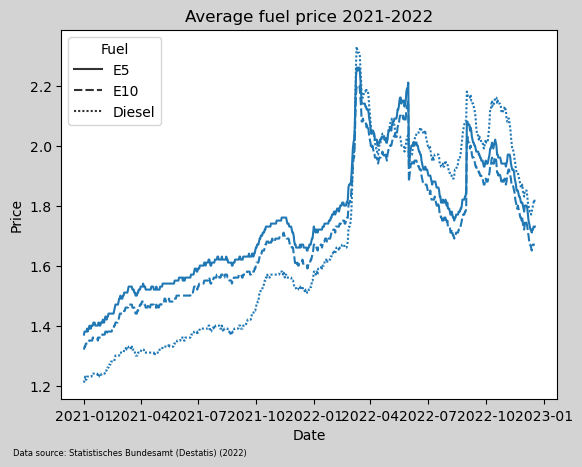

In [3]:
#|echo: false

gas_data = pd.read_excel('MTS_K_Kraftstoffpreise.xlsx', 'Daten')
gas_data.columns = ['Date', 'E5', 'E10','Diesel']
gas_data = gas_data#[gas_data.Date.dt.year==2021]
gas_data = gas_data.melt(id_vars='Date',var_name='Fuel',value_name='Price')

fig = plt.figure()
fig.patch.set_facecolor('lightgray')

sns.lineplot(x="Date", y="Price",
             style="Fuel", #style="event",
             data=gas_data)

plt.title('Average fuel price 2021-2022')
plt.annotate('Data source: Statistisches Bundesamt (Destatis) (2022)', (0,0), (-35,-35), fontsize=6, 
             xycoords='axes fraction', textcoords='offset points', va='top')
plt.show()

2021 was a pretty normal year, fuel prices slightly increased, with some noisy up and downs. 2022 was really crazy with high raises and steep dives of the fuel price.

Since our car is using Diesel I'll do the following simulations for Diesel. Our car is driving approximately *12,000 km* per year and has a consumption of *6.4 liters per 100 km*. In our example we assume we drive the same distance with the same consumption on everyday of the year.

::: {.column-margin}
12,000 km/year

0.064 l/km

2.104 l/day
:::


We'll compare three different refueling strategies:

- **Strategy 1: Fixed payment:** 

    We refuel for exactly *€ 45* when tank has *less than 10 liters*. The tank has a capacity of 55 liters, hence fuel for € 45 fits when we refuel. This refers to the "joke" strategy.
    
- **Strategy 2: Regularly, fixed amount of fuel:** 

    In this strategy we refill *every 15 days* the same amount of fuel regardless of the price. That's viable, because we are consuming the same amount of fuel everyday.
    
- **Strategy 3: Fill on lowest price:**

    We have a magic crystal ball and know every price in advance. So we (partially) refuel always on the *lowest price* in a 20 day window. 
    


In [4]:
#|include: false

def gas_simu(year = 2021):
    days_hd = 15
    window=20
    liter_threshold=10
    const_amount = 45
    consumption = 6.4*120/365 # liter per day

    gas_data = pd.read_excel('MTS_K_Kraftstoffpreise.xlsx', 'Daten')
    gas_data.columns = ['Date', 'E5', 'E10','Diesel']
    gas_data = gas_data[gas_data.Date.dt.year==year].reset_index(drop=True)

    gas_data[f'liter_per_{const_amount}eur'] = const_amount/gas_data.Diesel
    gas_data['cons_roll'] = consumption * (1+gas_data.index)

    gas_data.loc[0,'Liter same amount']=liter_threshold+gas_data.loc[0,f'liter_per_{const_amount}eur']-consumption
    gas_data.loc[0,f'€ {const_amount} everytime'] = gas_data.loc[0,'Diesel']
    for i in gas_data.index.values[1:]:
        gas_data.loc[i,'Liter same amount'] = gas_data.loc[i-1,'Liter same amount'] + (gas_data.loc[i,f'liter_per_{const_amount}eur'] if gas_data.loc[i-1,'Liter same amount']<=liter_threshold else 0)-consumption
        gas_data.loc[i,f'€ {const_amount} everytime'] = gas_data.loc[i,'Diesel'] if gas_data.loc[i-1,'Liter same amount']<=liter_threshold else None
    gas_data[f'€ {const_amount} everytime'] = gas_data[f'€ {const_amount} everytime'].fillna(method="ffill")

    gas_data.loc[gas_data.index%days_hd==0, 'Liter cont.'] = 35
    gas_data.loc[gas_data.index%days_hd==0, f'every {days_hd} days'] = gas_data.Diesel
    gas_data[f'every {days_hd} days'] = gas_data[f'every {days_hd} days'].fillna(method="ffill")
    gas_data.loc[gas_data.index%days_hd==0, 'Liter fill'] = 35
    for i in range(21):
        gas_data[f'rm_{i}']=gas_data.Diesel.shift(i)
    gas_data[f'best price within {window} days'] = gas_data[[f'rm_{i}' for i in range(21)]].fillna(99999).min(axis=1)
    gas_data['Refuel worst 10'] = gas_data[[f'rm_{i}' for i in range(21)]].fillna(0).max(axis=1)
    gas_data['Refuel vola 10'] = gas_data[[f'rm_{i}' for i in range(21)]].std(axis=1)

    gas_data_melt = gas_data[['Date',f'€ {const_amount} everytime',f'every {days_hd} days',f'best price within {window} days']].melt(id_vars=['Date'],var_name='Refueling strategies',value_name='Price')
    
    avg_price_fixed_pay, avg_price_fixed_fuel, avg_price_cheapest = gas_data[['Date',f'€ {const_amount} everytime',f'every {days_hd} days',f'best price within {window} days']].mean().values

    stops=gas_data[~(gas_data[f'€ {const_amount} everytime']==gas_data[f'€ {const_amount} everytime'].shift(1))].reset_index()[['index']]
    stops_fixed_pay= (((stops['index']-stops['index'].shift(1))//20).sum()+stops.shape[0])

    stops=gas_data[~(gas_data[f'every {days_hd} days']==gas_data[f'every {days_hd} days'].shift(1))].reset_index()[['index']]
    stops_fixed_fuel = (((stops['index']-stops['index'].shift(1))//20).sum()+stops.shape[0])

    stops=gas_data[~(gas_data[f'best price within {window} days']==gas_data[f'best price within {window} days'].shift(1))].reset_index()[['index']]
    stops_cheapest= (((stops['index']-stops['index'].shift(1))//20).sum()+stops.shape[0])
    
    return gas_data, gas_data_melt, avg_price_fixed_pay, avg_price_fixed_fuel, avg_price_cheapest, stops_fixed_pay, stops_fixed_fuel, stops_cheapest

In [5]:
#|include: false

gas_data, gas_data_melt, avg_price_fixed_pay, avg_price_fixed_fuel, avg_price_cheapest, stops_fixed_pay, stops_fixed_fuel, stops_cheapest = gas_simu(year = 2021)


/tmp/ipykernel_361/1320793745.py:36: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  avg_price_fixed_pay, avg_price_fixed_fuel, avg_price_cheapest = gas_data[['Date',f'€ {const_amount} everytime',f'every {days_hd} days',f'best price within {window} days']].mean().values


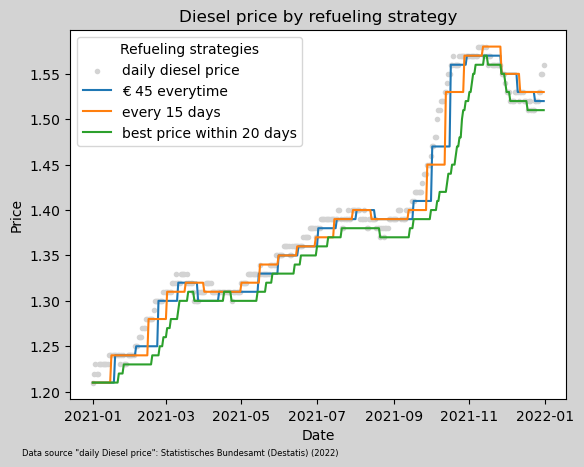

In [6]:
#|echo: false

fig = plt.figure()
fig.patch.set_facecolor('lightgray')

plt.scatter(gas_data.Date,gas_data.Diesel, label = 'daily diesel price', marker = '.', color='lightgray')

sns.lineplot(x="Date", y="Price",
             hue="Refueling strategies",
             data=gas_data_melt)

plt.title('Diesel price by refueling strategy')
plt.annotate('Data source "daily Diesel price": Statistisches Bundesamt (Destatis) (2022)', (0,0), (-35,-35), fontsize=6, 
             xycoords='axes fraction', textcoords='offset points', va='top')

plt.show()

The chart shows the price of the consumed fuel on every day for each of the strategy. For example, when we refuel with strategy 2 on January 16th for € 1.24/l we'll consume Diesel worth € 1.24/l for the next 15 days.

Obviously, strategy 3 always has the lowest price. The average price and the yearly consumption for the three strategies are:

In [7]:
#|echo: false

md(f'''
- Strategy 1: € {avg_price_fixed_pay: ,.4f}/l => € {avg_price_fixed_pay*6.4*120: ,.0f}/year
- Strategy 2: € {avg_price_fixed_fuel: ,.4f}/l => € {avg_price_fixed_fuel*6.4*120: ,.0f}/year
- Strategy 3: € {avg_price_cheapest: ,.4f}/l => € {avg_price_cheapest*6.4*120: ,.0f}/year

Which leads to a total saving of € {(avg_price_fixed_pay-avg_price_cheapest)*6.4*120: ,.2f}/year if we could predict the cheapest price for the next 20 days 
compared to strategy 1 and € {(avg_price_fixed_fuel-avg_price_cheapest)*6.4*120: ,.2f}/year compared to strategy 2.

That doesn't sound much, but it's still a saving of approximately {(avg_price_fixed_pay-avg_price_cheapest)/avg_price_fixed_pay*100: ,.2f}% or 
additional fuel for a {12000*(avg_price_fixed_pay-avg_price_cheapest)/avg_price_fixed_pay: ,.0f} km drive.

When we look a bit closer at the chart, we see that the *best price strategy* line is very fine grained and the other two strategies are more bumpy 
with long flat plateaus. This indicates, that to accomplish the best price strategy, we need to hit the gas station more often.
Here are the number of pit stops needed for the three strategies:

- Strategy 1: {stops_fixed_pay: ,.0f} stops
- Strategy 2: {stops_fixed_fuel: ,.0f} stops
- Strategy 3: {stops_cheapest: ,.0f} stops

This is a total different picture. To achieve a saving of € {(avg_price_fixed_pay-avg_price_cheapest)*6.4*120: ,.2f}/year 
I would not only need the magic crystal ball, but I would also need to make {stops_cheapest-stops_fixed_pay:,.0f} more stops at the gas station per year. 
Let's say one stop takes 10 minutes (waiting in line, refueling, paying), that would result in an additional {(stops_cheapest-stops_fixed_pay)*10/60:,.2f} hours per year 
spending at the gas station.

During this additional {(stops_cheapest-stops_fixed_pay)*10/60:,.2f} hours I can walk with my daughter at 4km/h her daily 2x2km march to kindergarten 
{(stops_cheapest-stops_fixed_pay)*10/60 * 4 / 4: ,.0f} times. Which is {(stops_cheapest-stops_fixed_pay)*10/60 * 4: 0,.1f} km or a Diesel saving of 
€ {(stops_cheapest-stops_fixed_pay)*10/60 * 4*avg_price_fixed_pay*6.4/100: 0,.1f} in strategy 1 and 
if I take insurance, taxes, regular maintenance and car depreciation into account it's a saving of € {(stops_cheapest-stops_fixed_pay)*10/60 * 4*0.36: 0,.1f} (with 0.36 ct/km in 2021).
''')


- Strategy 1: €  1.3812/l => €  1,061/year
- Strategy 2: €  1.3829/l => €  1,062/year
- Strategy 3: €  1.3628/l => €  1,047/year

Which leads to a total saving of €  14.10/year if we could predict the cheapest price for the next 20 days 
compared to strategy 1 and €  15.38/year compared to strategy 2.

That doesn't sound much, but it's still a saving of approximately  1.33% or 
additional fuel for a  159 km drive.

When we look a bit closer at the chart, we see that the *best price strategy* line is very fine grained and the other two strategies are more bumpy 
with long flat plateaus. This indicates, that to accomplish the best price strategy, we need to hit the gas station more often.
Here are the number of pit stops needed for the three strategies:

- Strategy 1:  24 stops
- Strategy 2:  24 stops
- Strategy 3:  54 stops

This is a total different picture. To achieve a saving of €  14.10/year 
I would not only need the magic crystal ball, but I would also need to make 30 more stops at the gas station per year. 
Let's say one stop takes 10 minutes (waiting in line, refueling, paying), that would result in an additional 5.00 hours per year 
spending at the gas station.

During this additional 5.00 hours I can walk with my daughter at 4km/h her daily 2x2km march to kindergarten 
 5 times. Which is  20.0 km or a Diesel saving of 
€  1.8 in strategy 1 and 
if I take insurance, taxes, regular maintenance and car depreciation into account it's a saving of €  7.2 (with 0.36 ct/km in 2021).


Now, that we have a picture of 2021 and can decide on our personal preference and clairvoyant abilities to abondon or to go for Strategy 3, we still don't have a clear picture of Strategy 1 and 2. In 2021 they look pretty similar with the given parameters. But it's also clear, that we would have to make more gas station stops, if we'd either lower the fixed paying amount of strategy 1 or if we'd shorten the refilling interval of strategy 2.

Let's see what happens when the prices go crazy like in 2022.



In [8]:
#|include: false

gas_data, gas_data_melt, avg_price_fixed_pay, avg_price_fixed_fuel, avg_price_cheapest, stops_fixed_pay, stops_fixed_fuel, stops_cheapest = gas_simu(year = 2022)


/tmp/ipykernel_361/1320793745.py:36: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  avg_price_fixed_pay, avg_price_fixed_fuel, avg_price_cheapest = gas_data[['Date',f'€ {const_amount} everytime',f'every {days_hd} days',f'best price within {window} days']].mean().values


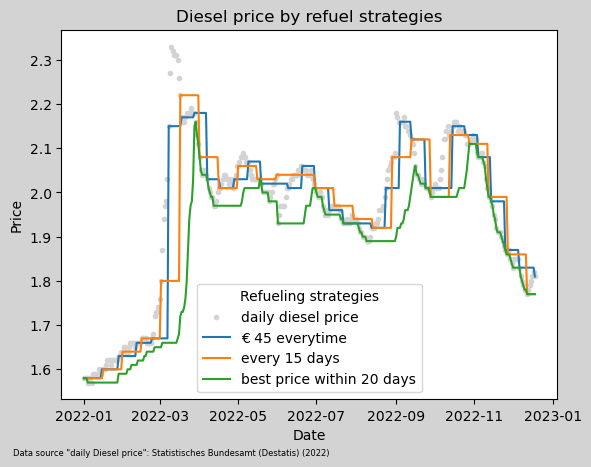

In [9]:
#|echo: false

fig = plt.figure()
fig.patch.set_facecolor('lightgray')

plt.scatter(gas_data.Date,gas_data.Diesel, label = 'daily diesel price', marker = '.', color='lightgray')

sns.lineplot(x="Date", y="Price",
             hue="Refueling strategies",
             data=gas_data_melt)

plt.title('Diesel price by refuel strategies')
plt.annotate('Data source "daily Diesel price": Statistisches Bundesamt (Destatis) (2022)', (0,0), (-35,-35), fontsize=6, 
             xycoords='axes fraction', textcoords='offset points', va='top')

plt.show()

In [10]:
#|echo: false

md(f'''
These are the numbers for 2022:

- Strategy 1: € {avg_price_fixed_pay: ,.4f}/l => € {avg_price_fixed_pay*6.4*120: ,.0f}/year => {stops_fixed_pay: ,.0f} stops
- Strategy 2: € {avg_price_fixed_fuel: ,.4f}/l => € {avg_price_fixed_fuel*6.4*120: ,.0f}/year => {stops_fixed_fuel: ,.0f} stops
- Strategy 3: € {avg_price_cheapest: ,.4f}/l => € {avg_price_cheapest*6.4*120: ,.0f}/year => {stops_cheapest: ,.0f} stops

Which result in savings and additional hours spent at the gas station as shown below:
''')


These are the numbers for 2022:

- Strategy 1: €  1.9517/l => €  1,499/year =>  33 stops
- Strategy 2: €  1.9481/l => €  1,496/year =>  24 stops
- Strategy 3: €  1.8818/l => €  1,445/year =>  111 stops

Which result in savings and additional hours spent at the gas station as shown below:


In [11]:
#|include: false

sav_mx = np.array([avg_price_fixed_pay,avg_price_fixed_fuel,avg_price_cheapest])*6.4*120
sav_mx=-np.subtract.outer(sav_mx,sav_mx)

stops_mx = np.array([stops_fixed_pay,stops_fixed_fuel,stops_cheapest])*10/60
stops_mx=np.subtract.outer(stops_mx,stops_mx)

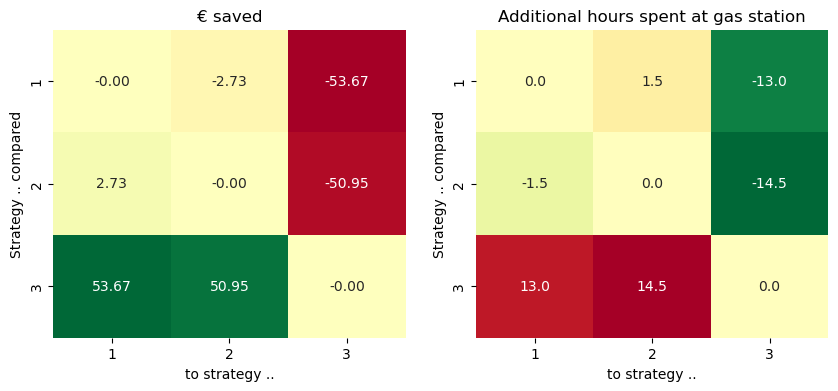

In [12]:
#|echo: false

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

sns.heatmap(sav_mx, cmap='RdYlGn', annot=True, fmt=".2f", cbar=False, ax=ax1)
ax1.set(xlabel="to strategy ..", ylabel="Strategy .. compared", 
       xticklabels=[1,2,3], yticklabels=[1,2,3], 
       title = '€ saved')

sns.heatmap(stops_mx, cmap='RdYlGn_r', annot=True, fmt=".1f", cbar=False, ax=ax2)
ax2.set(xlabel="to strategy ..", ylabel="Strategy .. compared", 
       xticklabels=[1,2,3], yticklabels=[1,2,3], 
       title = 'Additional hours spent at gas station')

plt.show()

In 2022 strategy 2 is superior to strategy 1. The higher number of gas station stops results from not adjusting the fixed payment amount to the higher prices.

# Conclusion
The old joke is worn out. 

A) No one can predict the prices precisely.
B) Waiting at the gas station for a € 3-4/hours "salary" doesn't make sense, if you can effort a car in Germany. 

After comparing the three strategies with the data from 2021 and 2022 I personally prefer strategy number 2. Which leads me to these life hacks:

:::{.callout-tip}
## Life hacks
- Default to not taking the car, instead
    - commute by walking, train, bus, bike, stay at home, share rides,
    - go shopping by walking, train, bus, bike, shop online,
    - go to kindergarten/School by walking, train, bus, bike.
- Don't bother about the fuel price.
- Refuel the entire tank.
- Refuel early if you fear traffic jams in winter. A diesel fueled car is basically a moving heating. A diesel car only uses about half of the fuel provided energy to actually move the car (@tuev_nord_2023). And even less if we don't press the pedal all the way down. The rest results in heat. And if we leave the heating on, while waiting in traffic jam in winter, we can watch the tank go empty, quickly. 
:::